In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Introduction
I work in the field of cybersecurity. In general, the way that malware and other forms of malicious activity are detected is using signature matching. Essentially, network traffic is compared against a set of known signatures related to various forms of malicious activity. The capabilities of signature matching are limited. Signature-matching systems can be easily fooled by making minor modifications to the malicious activity. For example, say a signature looks for the string “This program cannot be run in DOS mode”, which is a string that is standard for the MS-DOS header that is part of a Microsoft Portable Executable file. It is trivial to fool a signature-matching system by adding additional blank spaces to the string. Because of the limitations of signature matching, there has been a push in the field to start implementing behavior analysis as a method of detecting malicious activity. This is because, while it is easy to slightly modify software, it is much more difficult to modify behavior, as shown by the fact that every malicious actor has a known set of Tactics, Techniques, and Procedures (TTPs) that rarely changes. Machine learning provides a potential method for evaluating traffic without relying on signatures. 

Additionally, signature matching is only feasible if you have access to full packet captures (PCAPs), which are extremely large. Depending on the size of the network from which the PCAPs were taken, even maintaining a week's worth of PCAPs can require many Terabytes worth of storage. However, another type of data that can be generated from network traffic. Flow data (often called netflow data) summarizes network traffic, separating it into connections. Flow data is significantly smaller than full PCAP data, 100 times smaller or more. Flow data can easily be converted into matrices, upon which machine learning can work.

Because of the cost of implementing signature matching and its limitations, I used this project as a way to answer two questions. 
1. Can machine learning be applied to flow data to accurately classify network traffic as either benign or malicious? 
2. If so, which parts of flow data (features) are the most useful for classifying network traffic?

## Importing the Data

For this project, I took flow data that was generated from PCAPs. Due to the size of the available data, I only used a single PCAP and its corresponding flow data. Specifically, I used the data that covers Thursday morning, which includes benign traffic and traffic from 3 types of Web Attacks: Brute Force, SQL Injection, and XSS (Cross-site scripting). 

The original PCAP is 7.7 GB (it covers all of Thursday) is size with the CSV file containing the corresponding netflow data (for Thursday morning) being almost 90 MB, including more than 170,000 examples with 82 features. Due to the nature of network traffic, the data is heavily imbalanced, skewing toward benign samples, with less than 2200 samples that represent all of the attack types and the rest being benign.

Part of importing the data involved performing some transformations so it would work with sklearn. I decided to use a Random Forest Classifier (more on that below) which would normally be able to handle both categorical and numeric (continuous) data. However, sklearn's implementation of the Random Forest Classifier doesn't do so internally. It only uses numerical features which are always interpreted as continuous. Thankfully, the only non-numerical data in my dataset is the IP addresses. Since IP addresses are themselves numeric (they are just presented in dotted decimal notation for readability), they can easily be converted into a completely numeric format. I also had to replace the 'NaN' and 'Infinity' values. Since they were the product of dividing by zero, I replaced them with 0.

In [ ]:
import requests
import ipaddress

def make_column(column):
    try:
        result = column.astype(np.float_)[:,np.newaxis]
        result = np.nan_to_num(result, nan=0, posinf=0, neginf=0)
    except:
        int_column = np.array([int(ipaddress.ip_address(column[i])) for i in range(len(column))])
        result = int_column[:,np.newaxis]
    return result

def make_y(y_strings):
    labels = np.unique(y_strings)
    y = np.zeros(len(y_strings))
    for i in range(len(labels)):
        y[y_strings == labels[i]] = i
    return y, labels

# import data from CSV (possibly saved locally with the notebook, on a CS machine, or in Google Drive)
def get_data(url):
    data_string = requests.get(url).text
    data_lines = data_string.split('\n')
    data_lines[0] = data_lines[0][1:]
    data_lines[0] = data_lines[0].replace(', ', ',')
    data_lines.pop(170367)
    string_matrix = np.array([row.split(',') for row in data_lines], dtype=str)

    headers = string_matrix[0][:-1]
    string_matrix = string_matrix[1:]
    columns = [make_column(string_matrix[:,i]) for i in range(len(string_matrix[0])-1)]
    X = np.concatenate(columns, axis=1)
    y_strings = np.array(string_matrix[:,-1])
    y, labels = make_y(y_strings)

    return X, y, headers, labels

link = 'https://raw.githubusercontent.com/nritter8/cs345-project/main/flow_data.csv'
X, y, headers, labels = get_data(link)

In [ ]:
print(headers, '\n\n', labels, '\n\n', X.shape, y.shape)
print('\n', X[:,1].dtype)

['Source IP' 'Source Port' 'Destination IP' 'Destination Port' 'Protocol'
 'Flow Duration' 'Total Fwd Packets' 'Total Backward Packets'
 'Total Length of Fwd Packets' 'Total Length of Bwd Packets'
 'Fwd Packet Length Max' 'Fwd Packet Length Min' 'Fwd Packet Length Mean'
 'Fwd Packet Length Std' 'Bwd Packet Length Max' 'Bwd Packet Length Min'
 'Bwd Packet Length Mean' 'Bwd Packet Length Std' 'Flow Bytes/s'
 'Flow Packets/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Total' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max'
 'Fwd IAT Min' 'Bwd IAT Total' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max'
 'Bwd IAT Min' 'Fwd PSH Flags' 'Bwd PSH Flags' 'Fwd URG Flags'
 'Bwd URG Flags' 'Fwd Header Length' 'Bwd Header Length' 'Fwd Packets/s'
 'Bwd Packets/s' 'Min Packet Length' 'Max Packet Length'
 'Packet Length Mean' 'Packet Length Std' 'Packet Length Variance'
 'FIN Flag Count' 'SYN Flag Count' 'RST Flag Count' 'PSH Flag Count'
 'ACK Flag Count' 'URG Flag Count' 'CWE Flag Coun

The most basic flow data is known as the 5-tuple and it consists of the following:
- source and destination IP addresses
- source and destination ports, if any (not all traffic uses TCP/UDP ports)
- communication protocol

As such, I created a reduced feature matrix that only includes the 5-tuple as the features.

In [ ]:


def get_5_tuple(X, headers):
    tuple_headers = ['Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Protocol']
    column_nos = []
    for i in range(len(headers)):
        if headers[i] in tuple_headers:
            column_nos.append(i)
    tuple_columns = [make_column(X[:, i]) for i in column_nos]
    basic_X = np.concatenate(tuple_columns, axis=1)
    return basic_X

basic_X = get_5_tuple(X, headers)
print(basic_X.shape, basic_X.dtype)


(170366, 5) float64


## Initial classification

The best classifier to use for my data is the Random Forest Classifier, for the following reasons:
- Random Forests reduce processing overhead since the features don't need to be standardized
- The data has four possible classes (benign and 3 attacks) and Random Forests are inherently multiclass
- The data has over 170,000 examples which makes Random Forests, with a training complexity of $O(n * log(n) * d * k)$[<sup>1</sup>](#complexity) preferable to other classifiers, such as SVMs, which have a training complexity of $O(n^2)$[<sup>1</sup>](#complexity)

However, Random Forests have a tendency to overfit data, so I tested different values for the maximum tree depth, using balanced accuracy as the measure of classifier performance due to the significant imbalance in the data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

basic_accuracies = []
full_accuracies = []

def classify(X, y, d):
    cv = StratifiedKFold(shuffle=True, random_state=42)
    forest = RandomForestClassifier(max_depth=d)
    accuracy = cross_val_score(forest, X, y, cv=cv, scoring='balanced_accuracy')
    return np.mean(accuracy)

def check_depths(X, y):
    accuracies = []
    for depth in range(4,40,4):
        accuracies.append(classify(X, y, depth))
    return accuracies

basic_accuracies = check_depths(basic_X, y)
full_accuracies = check_depths(X, y)

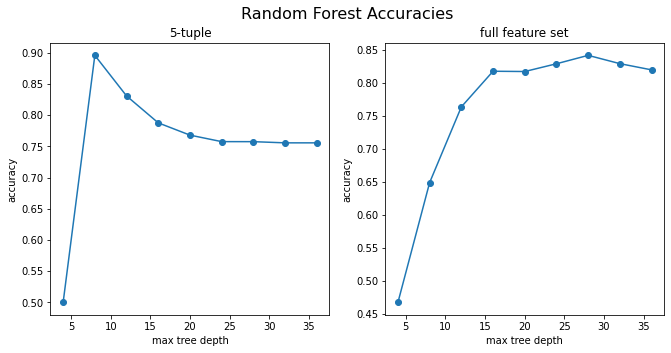

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))

axs[0].plot(range(4,40,4), basic_accuracies, 'o-')
axs[1].plot(range(4,40,4), full_accuracies, 'o-')

fig.suptitle('Random Forest Accuracies', fontsize=16)
axs[0].set_title('5-tuple')
axs[1].set_title('full feature set')
for i in [0,1]:
    axs[i].set_xlabel('max tree depth')
    axs[i].set_ylabel('accuracy')

plt.show()

On the whole, the accuracy of the classifier is around what I thought it would be. The balanced accuracy is significantly higher than it would be for a majority classifier (0.25), but the balanced accuracy being around 0.83, while decent, suggests that using flow data might not quite be sufficient for accurately classifying network traffic into different attacks, which answers my first question.

The results also give two other important pieces of information. The first is the optimal maximum tree depth to use for classifying network traffic using a Random Forest Classifier, which is 28 for the full feature set and 8 for the 5-tuple. While useful for tuning the classifier, maximum tree depth doesn't say anything about the data.

The second piece of information is much more useful for determining what is needed to classify network traffic. The results say that using the basic 5-tuple is as good as, if not better than using the full feature set, with the accuracy being up to 0.05 higher.

## Feature Selection

After finding the optimal maximum tree depth for the Random Forest Classifier, I wanted to determine which features of the netflow data are the most useful for classifying network traffic. The quickest and easiest way to determine the importance of each feature when using a Random Forest Classifier is to check its *feature_importances_* property.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

best_forest = RandomForestClassifier(max_depth=20)
best_forest.fit(X_train, y_train);

In [ ]:
from operator import itemgetter

importances = []
for i in range(len(X[0])):
    importance = {'index': i, 'value': best_forest.feature_importances_[i]}
    importances.append(importance)
importances.sort(key=itemgetter('value'), reverse=True)
for i in range(10):
    print(headers[importances[i]['index']], importances[i]['value'])

Source IP 0.14094694009690556
Source Port 0.08495751028048876
Fwd IAT Min 0.05383631847732424
Fwd IAT Std 0.050171109983477
Destination IP 0.05003235221293596
Flow IAT Std 0.04576964713579074
Init_Win_bytes_backward 0.03587473898209669
Fwd Header Length 0.03523108493270867
Destination Port 0.033269784148128353
Flow IAT Min 0.029004583323762535


The above are the most important features of flow data for classifying network traffic, with 4 of the elements of the 5-tuple being present in the top 10 features (3 of which are in the top 5).

If the balanced accuracy is evaluated after the data is limited only to the $3 \ge n \ge 18$ most important features, a more complete picture of the importances of the different features can be seen. I also rechecked each limited feature set with different maximum depths to see if it made a noticable difference.

In [ ]:
accuracy_matrix = []
for d in range(12,21,4):
    accuracies = []
    for n in range(3,20,3):
        best_headers = np.array([importances[i]['index'] for i in range(n)])
        best_columns = [make_column(X[:, i]) for i in best_headers]
        X_best = np.concatenate(best_columns, axis=1)
        accuracies.append(classify(X_best, y, d))
    accuracy_matrix.append(accuracies)

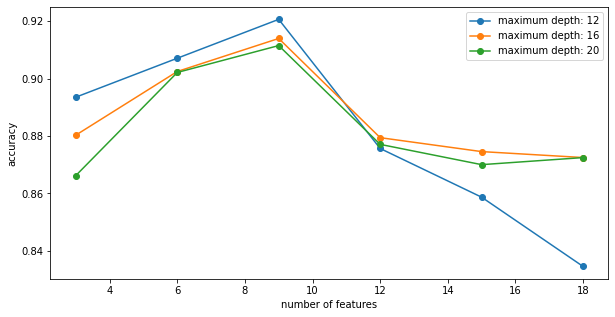

In [ ]:
fig, ax5 = plt.subplots(1, 1, figsize=(10,5))

for i in range(len(accuracy_matrix)):
    label = 'maximum depth: ' + str(12 + 4*i)
    ax5.plot(range(3,20,3), accuracy_matrix[i], 'o-', label=label)
ax5.set_xlabel('number of features')
ax5.set_ylabel('accuracy')
ax5.legend()

This shows that, while some features are more important than others, a Random Forest Classifier requires around 10 features from flow data to achieve the best accuracy.

## Rethinking the Classes

While my results made sense, I wasn't satisfied with the accuracy I had achieved. I decided to see if changing my classification requirements would help. Instead of classifying each of the 3 types of attacks separately, I tried combining them so that the classifier only had to distinguish between two classes: benign traffic and malicious traffic.

In [ ]:
simplified_accuracies = []

y_simplified = y > 0
best_headers = np.array([importances[i]['index'] for i in range(10)])
best_columns = [make_column(X[:, i]) for i in best_headers]
best_X = np.concatenate(best_columns, axis=1)

simplified_accuracies.append(classify(X, y_simplified, 20))
simplified_accuracies.append(classify(best_X, y_simplified, 10))
simplified_accuracies.append(classify(basic_X, y_simplified, 10))
s_accuracies_matrix = np.array(simplified_accuracies)

In [ ]:
pd.DataFrame(simplified_accuracies, columns=['Accuracy'], index=['Full Feature Set', 'Best 10 Features', '5-Tuple'])

,Accuracy
Full Feature Set,0.998392
Best 10 Features,0.999982
5-Tuple,0.998600


As I expected, when I reduce the number of classes, the accuracy of the classifier increases. However, I did not expect it to increase as much as it did. An accuracy of 0.99 leaves little doubt that a Random Forest classifier could accurately classify network traffic as either benign or malicious.

## Conclusion

I originally set out to answer two questions:
1. Can machine learning be applied to flow data to accurately classify network traffic as either benign or malicious? 
  - Machine learning, when applied to flow data, even the basic 5-tuple, can accurately classify network traffic as either benign or malicious. It still does well at classifying network traffic by attack type, although less so than a simple binary classification, so other approaches to identifying different types of attacks are likely preferable.

2. If so, which parts of flow data (features) are the most useful for classifying network traffic?
  - The basic 5-tuple is some of the most useful data for classifying network traffic. There are other features that are also very useful, but they require more work to extract from network traffic.

Said questions have been sufficiently answered.

###Footnotes

<span id="complexity"> [1]
>n = number of training examples  
>d = number of data dimensions/features  
>k = number of decision trees
</span>